## Time Series Forecasting: Stock Price Prediction with LSTM

Here we are building a complete time series forecasting project using LSTM neural networks to predict stock prices. We'll use real API data and create a deployable application.

In [1]:
# Install required packages
#pip install yfinance pandas numpy matplotlib scikit-learn tensorflow streamlit plotly

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

Now lets Fetch Real Stock Data via API

In [2]:
def fetch_stock_data(symbol, period="2y"):
    """
    Fetch stock data from Yahoo Finance API
    """
    try:
        stock = yf.Ticker(symbol)
        data = stock.history(period=period)

        if data.empty:
            raise ValueError(f"No data found for symbol {symbol}")

        print(f"✅ Successfully fetched {len(data)} days of data for {symbol}")
        return data

    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return None

# Test with Apple stock
symbol = "AAPL"
stock_data = fetch_stock_data(symbol)
print(stock_data.head())

✅ Successfully fetched 502 days of data for AAPL
                                 Open        High         Low       Close  \
Date                                                                        
2023-10-18 00:00:00-04:00  173.876881  175.857481  173.411439  174.134354   
2023-10-19 00:00:00-04:00  174.332417  176.114961  173.490671  173.758057   
2023-10-20 00:00:00-04:00  173.609501  173.718435  170.965402  171.203079   
2023-10-23 00:00:00-04:00  169.252191  172.322112  168.281686  171.321915   
2023-10-24 00:00:00-04:00  171.371413  171.985394  169.786927  171.757629   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-10-18 00:00:00-04:00  54764400        0.0           0.0  
2023-10-19 00:00:00-04:00  59302900        0.0           0.0  
2023-10-20 00:00:00-04:00  64244000        0.0           0.0  
2023-10-23 00:00:00-04:00  55980100        0.0           0.0  
2023-10-24 00:00:00-04:00  438166

## Data Preprocessing & Feature Engineering

In [3]:
def prepare_data(data, lookback_days=60):
    """
    Prepare data for LSTM training
    """
    # Use only closing prices
    prices = data['Close'].values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(prices)

    # Create sequences for LSTM
    X, y = [], []
    for i in range(lookback_days, len(scaled_prices)):
        X.append(scaled_prices[i-lookback_days:i, 0])
        y.append(scaled_prices[i, 0])

    X, y = np.array(X), np.array(y)

    # Reshape for LSTM (samples, time steps, features)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    return X, y, scaler

# Prepare the data
lookback = 60
X, y, scaler = prepare_data(stock_data, lookback_days=lookback)

print(f"📊 Data shape: {X.shape}")
print(f"📈 Training samples: {len(X)}")

📊 Data shape: (442, 60, 1)
📈 Training samples: 442


# Now Build & Train LSTM Model

🧠 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

🚀 Training LSTM model...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - loss: 0.0479 - mae: 0.1790 - val_loss: 0.0808 - val_mae: 0.2468
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0560 - mae: 0.1871 - val_loss: 0.0262 - val_mae: 0.1311
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0341 - mae: 0.1587 - val_loss: 0.0229 - val_mae: 0.1226
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0349 - mae: 0.1645 - val_loss: 0.0125 - val_mae: 0.0903
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0242 - mae: 0.1320 - val_loss: 0.0195 - val_mae: 0.1151
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0182 - mae: 0.1132 - val_loss: 0.0068 - val_mae: 0.0661
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0131 - mae: 0.0948 - val_loss: 0.0305 - val_mae: 0.1517
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0169 - mae: 0.0998 - val_loss: 0.0065 - val_mae: 0.0656
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━

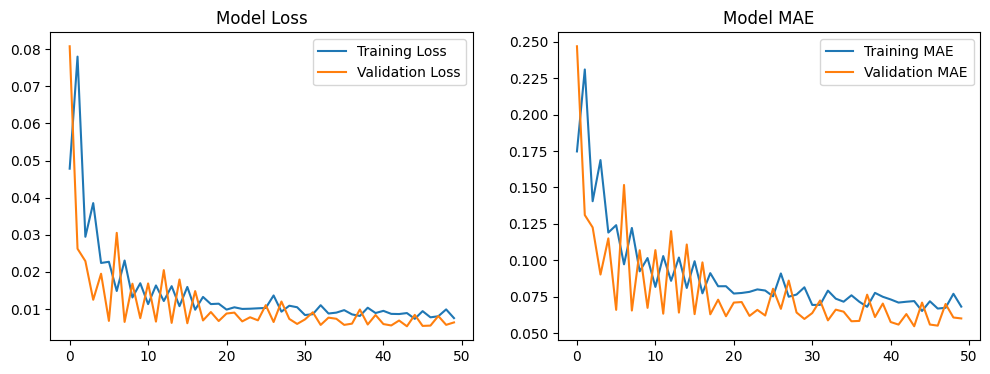

In [4]:
def build_lstm_model(input_shape):
    """
    Build LSTM model for time series forecasting
    """
    model = Sequential([
        # First LSTM layer
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(50, return_sequences=True),
        Dropout(0.2),

        # Third LSTM layer
        LSTM(50, return_sequences=False),
        Dropout(0.2),

        # Output layer
        Dense(25),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

# Build the model
model = build_lstm_model((X.shape[1], 1))
print("🧠 Model Architecture:")
model.summary()

# Train the model
def train_model(model, X, y, validation_split=0.2, epochs=50):
    """
    Train the LSTM model
    """
    history = model.fit(
        X, y,
        batch_size=32,
        epochs=epochs,
        validation_split=validation_split,
        verbose=1,
        shuffle=False  # Important for time series!
    )

    return history

# Train the model
print("🚀 Training LSTM model...")
history = train_model(model, X, y, epochs=50)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.legend()
plt.show()

# Make Prediction

In [5]:
def make_predictions(model, data, scaler, lookback_days=60):
    """
    Make predictions on the entire dataset
    """
    prices = data['Close'].values.reshape(-1, 1)
    scaled_prices = scaler.transform(prices)

    # Prepare test data
    X_test = []
    for i in range(lookback_days, len(scaled_prices)):
        X_test.append(scaled_prices[i-lookback_days:i, 0])

    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    return predictions

# Generate predictions
predictions = make_predictions(model, stock_data, scaler, lookback)

# Create results DataFrame
results = stock_data.iloc[lookback:].copy()
results['Predicted'] = predictions

print("📈 Prediction Results:")
print(results[['Close', 'Predicted']].tail())

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
📈 Prediction Results:
                                Close   Predicted
Date                                             
2025-10-13 00:00:00-04:00  247.660004  252.801270
2025-10-14 00:00:00-04:00  247.770004  251.156494
2025-10-15 00:00:00-04:00  249.339996  249.350449
2025-10-16 00:00:00-04:00  247.449997  247.753738
2025-10-17 00:00:00-04:00  252.289993  246.403107


## Visualization & Evaluation

In [6]:
def evaluate_model(results):
    """
    Evaluate model performance and create visualizations
    """
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import math

    actual = results['Close']
    predicted = results['Predicted']

    # Calculate metrics
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    r2 = r2_score(actual, predicted)

    print("📊 MODEL PERFORMANCE METRICS:")
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Create interactive plot
    fig = go.Figure()

    # Add actual prices
    fig.add_trace(go.Scatter(
        x=results.index,
        y=results['Close'],
        name='Actual Price',
        line=dict(color='blue', width=2)
    ))

    # Add predicted prices
    fig.add_trace(go.Scatter(
        x=results.index,
        y=results['Predicted'],
        name='Predicted Price',
        line=dict(color='red', width=2, dash='dash')
    ))

    fig.update_layout(
        title=f'Stock Price Prediction: {symbol}',
        xaxis_title='Date',
        yaxis_title='Price ($)',
        template='plotly_white'
    )

    return fig, {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Evaluate and visualize
plot, metrics = evaluate_model(results)
plot.show()

📊 MODEL PERFORMANCE METRICS:
Mean Absolute Error (MAE): $5.61
Root Mean Squared Error (RMSE): $7.46
R² Score: 0.9028


## Future Price Prediction

In [7]:
def predict_future_prices(model, data, scaler, lookback_days=60, future_days=30):
    """
    Predict future stock prices
    """
    # Get the last sequence from historical data
    prices = data['Close'].values.reshape(-1, 1)
    scaled_prices = scaler.transform(prices)

    # Last known sequence
    last_sequence = scaled_prices[-lookback_days:].flatten()

    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(future_days):
        # Reshape for prediction
        current_sequence_reshaped = current_sequence.reshape(1, lookback_days, 1)

        # Predict next day
        next_pred = model.predict(current_sequence_reshaped, verbose=0)[0, 0]
        future_predictions.append(next_pred)

        # Update sequence (remove first, add prediction)
        current_sequence = np.append(current_sequence[1:], next_pred)

    # Convert back to original scale
    future_predictions = scaler.inverse_transform(
        np.array(future_predictions).reshape(-1, 1)
    ).flatten()

    # Create future dates
    last_date = data.index[-1]
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=future_days,
        freq='D'
    )

    return future_dates, future_predictions

# Predict next 30 days
future_dates, future_prices = predict_future_prices(
    model, stock_data, scaler, future_days=30
)

print("🔮 Future Price Predictions:")
for date, price in zip(future_dates, future_prices):
    print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")

🔮 Future Price Predictions:
2025-10-18: $245.67
2025-10-19: $245.10
2025-10-20: $244.54
2025-10-21: $243.95
2025-10-22: $243.33
2025-10-23: $242.69
2025-10-24: $242.05
2025-10-25: $241.42
2025-10-26: $240.81
2025-10-27: $240.22
2025-10-28: $239.65
2025-10-29: $239.10
2025-10-30: $238.57
2025-10-31: $238.06
2025-11-01: $237.56
2025-11-02: $237.08
2025-11-03: $236.60
2025-11-04: $236.15
2025-11-05: $235.70
2025-11-06: $235.26
2025-11-07: $234.84
2025-11-08: $234.42
2025-11-09: $234.01
2025-11-10: $233.61
2025-11-11: $233.22
2025-11-12: $232.84
2025-11-13: $232.47
2025-11-14: $232.10
2025-11-15: $231.74
2025-11-16: $231.39
